<h1><center>Notebook de uso do modelo</center></h1>

#### Autor: Yan Vianna Sym

### Imports

In [1]:
import json
import requests
import socket
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

### Parametros que devem ser setados para escoragem

In [2]:
# nome da base que desejamos escorar mensalmente
nome_arquivo_input = 'default of credit card clients.xls'

# nome da base de saída com a resposta do modelo (ligar ou não ligar)
nome_arquivo_output = 'lista_ligacao.xlsx'

### Variáveis globais

In [3]:
threshold = 0.682
taxa_conversao = 0.18
PORT = "8888"
hostname = socket.gethostname()
CURRENT_IP = socket.gethostbyname(hostname)
address_post = "http://" + CURRENT_IP + ":" + PORT + "/predict"
header = {'Content-Type': 'application/json', 'Accept': 'application/json'}

dict_tipos = {'Valor':int,
'Genero':int,
'Grau_Educacao':int,
'Estado_Civil':int,
'Idade':int,
'Status_Pagamento_1':int,
'Status_Pagamento_2':int,
'Status_Pagamento_3':int,
'Status_Pagamento_4':int,
'Status_Pagamento_5':int,
'Status_Pagamento_6':int,
'Conta_Valor_1':float,
'Conta_Valor_2':float,
'Conta_Valor_3':float,
'Conta_Valor_4':float,
'Conta_Valor_5':float,
'Conta_Valor_6':float,
'Pagamento_Valor_1':float,
'Pagamento_Valor_2':float,
'Pagamento_Valor_3':float,
'Pagamento_Valor_4':float,
'Pagamento_Valor_5':float,
'Pagamento_Valor_6':float,
'Pagamento_Valor_6':float}

lista_colunas_leitura = ['Valor',
'Genero',
'Grau_Educacao',
'Estado_Civil',
'Idade',
'Status_Pagamento_1',
'Status_Pagamento_2',
'Status_Pagamento_3',
'Status_Pagamento_4',
'Status_Pagamento_5',
'Status_Pagamento_6',
'Conta_Valor_1',
'Conta_Valor_2',
'Conta_Valor_3',
'Conta_Valor_4',
'Conta_Valor_5',
'Conta_Valor_6',
'Pagamento_Valor_1',
'Pagamento_Valor_2',
'Pagamento_Valor_3',
'Pagamento_Valor_4',
'Pagamento_Valor_5',
'Pagamento_Valor_6']

lista_colunas_converter_moeda = ['Valor',
'Conta_Valor_1',
'Conta_Valor_2',
'Conta_Valor_3',
'Conta_Valor_4',
'Conta_Valor_5',
'Conta_Valor_6',
'Pagamento_Valor_1',
'Pagamento_Valor_2',
'Pagamento_Valor_3',
'Pagamento_Valor_4',
'Pagamento_Valor_5',
'Pagamento_Valor_6']

lista_colunas_modelo_final = ['Valor',
'Status_Pagamento_1',
'Conta_Slope',
'Pagamento_Conta_5',
'Pagamento_Valor_1',
'Idade',
'Pagamento_Valor_4',
'Pagamento_Valor_2',
'Pagamento_Conta_1',
'Pagamento_Valor_3',
'Pagamento_Conta_3',
'Pagamento_Intercept',
'Conta_Intercept',
'Pagamento_Slope',
'Conta_Valor_1',
'Pagamento_Conta_2',
'Pagamento_Conta_6',
'Pagamento_Valor_5',
'Pagamento_Conta_4',
'Conta_Valor_2',
'Status_Pagamento_6',
'Estado_Civil',
'Pagamento_Valor_count_1000',
'Genero',
'Pagamento_Valor_count_0',
'Conta_Valor_3',
'Status_Pagamento_3',
'Conta_Valor_count_0',
'Pagamento_Valor_6',
'Conta_Valor_4',
'Status_Pagamento_2',
'Conta_Valor_6',
'Grau_Educacao',
'Status_Pagamento_5',
'Status_Pagamento_4',
'Conta_Valor_5',
'Conta_Valor_count_10000']

### Metodos customizados

In [4]:
# Metodos customizados uteis para o problema
class HelperClass(object):
        
    # estrelas
    @staticmethod
    def stars():
        '''Alguns asteríscos apenas para formatação de output'''
        print ("*"*30)
        
    
    @staticmethod
    def conta_regressao(df):
        for i in range(len(df)):
            lista_valores = [df.iloc[i]["Conta_Valor_1"], df.iloc[i]["Conta_Valor_2"], df.iloc[i]["Conta_Valor_3"],
                             df.iloc[i]["Conta_Valor_4"], df.iloc[i]["Conta_Valor_5"], df.iloc[i]["Conta_Valor_6"]]
            slope, intercept, _, _, _ = stats.linregress([1,2,3,4,5,6], lista_valores)
            slope = round(slope, 2)
            intercept = round(intercept, 2)
            df.loc[df.index[i], "Conta_Slope"] = slope
            df.loc[df.index[i], "Conta_Intercept"] = intercept
        return df
    
    
    @staticmethod
    def pagamento_regressao(df):
        for i in range(len(df)):
            lista_valores = [df.iloc[i]["Pagamento_Valor_1"], df.iloc[i]["Pagamento_Valor_2"], df.iloc[i]["Pagamento_Valor_3"],
                             df.iloc[i]["Pagamento_Valor_4"], df.iloc[i]["Pagamento_Valor_5"], df.iloc[i]["Pagamento_Valor_6"]]
            slope, intercept, _, _, _ = stats.linregress([1,2,3,4,5,6], lista_valores)
            slope = round(slope, 2)
            intercept = round(intercept, 2)
            df.loc[df.index[i], "Pagamento_Slope"] = slope
            df.loc[df.index[i], "Pagamento_Intercept"] = intercept
        return df

    
    @staticmethod
    # conta quantos meses tiveram fatura ou pagamento menor ou igual ao threshold
    def contagem_threshold(df):
        data = df.copy()
        
        thresholds = [0,10000]
        label = "Conta_Valor_"
        
        for threshold in thresholds:
            for i in range(len(data)):
                count = 0
                for j in range(1,7):
                    if data.loc[data.index[i], label + str(j)] <= threshold:
                        count += 1
                data.loc[data.index[i], label + "count_" + str(threshold)] = count
                
        thresholds = [0,1000]
        label = "Pagamento_Valor_"
        
        for threshold in thresholds:
            for i in range(len(data)):
                count = 0
                for j in range(1,7):
                    if data.loc[data.index[i], label + str(j)] <= threshold:
                        count += 1
                data.loc[data.index[i], label + "count_" + str(threshold)] = count
                
        return data
    
    
    @staticmethod
    def funcao(x):
        return float(1)/float(1+np.exp(x))

    
    @staticmethod
    def funcao_pagamento(bill, pay):
        if bill > 0:
            if pay < bill:
                result = (pay/bill)
            else:
                result = 1 + HelperClass.funcao(pay)
        elif bill == 0:
            if pay != 0:
                result = 2 + HelperClass.funcao(pay)
            if pay == 0:
                result = 1
        else:
            if pay == 0:
                result = 3 + HelperClass.funcao(pay)
            if pay > 0:
                result = 4 + HelperClass.funcao(pay) 
        return result
    
    
    @staticmethod
    # calcula porcentagem do valor que foi pago
    def calcula_pagamento(df):
        data = df.copy()
        for i in range(len(data)):
            temp = pd.DataFrame.transpose(pd.DataFrame(data=data.iloc[i]))
            for j in range(1,7):
                temp.loc[j] = temp.iloc[0]
            temp["VAL"] = 0
            for j in range(1,7):
                bill = data.loc[data.index[i], "Conta_Valor_" + str(j)]
                pay = data.loc[data.index[i], "Pagamento_Valor_" + str(j)]
                data.loc[data.index[i], "Pagamento_Conta_" + str(j)] = HelperClass.funcao_pagamento(bill, pay)
        return data
    
    
    @staticmethod
    # metodo para implementar toda a engenharia de variaveis
    def implementa_engenharia_variaveis(df):
        df = HelperClass.conta_regressao(df)
        df = HelperClass.pagamento_regressao(df)
        df = HelperClass.contagem_threshold(df)
        df = HelperClass.calcula_pagamento(df)
        print ('Engenharia de variáveis finalizada...')
        return df
    
    
    @staticmethod
    # converte moeda de NT dolares para Reais
    def converte_moeda_reais(df, lista_colunas_converter_moeda, taxa_conversao):
        for column in lista_colunas_converter_moeda:
            df[column] = df[column] * taxa_conversao
        return df
    
    
    @staticmethod
    # pre processamento da base de entrada
    def formata_base_entrada(df):
        # renomeia colunas da base
        df.columns = lista_colunas_leitura

        # transforma a coluna para o tipo certo
        for column in df.columns.tolist():
            df[column] = df[column].astype(dict_tipos[column])
            
        # transforma genero em binário [0, 1] para facilitar o entendimento
        df['Genero'] = df['Genero'].map({2:1, 1:0})

        # Converte a moeda de NT Dolares para Reais
        df = HelperClass.converte_moeda_reais(df, lista_colunas_converter_moeda, taxa_conversao)

        # Engenharia de variáveis
        df = HelperClass.implementa_engenharia_variaveis(df)[lista_colunas_modelo_final]
        
        return df
    
    
    @staticmethod
    # monta lista de quem deve ser contactado para ofertas e renegociação e cobranças
    def monta_lista_ligacao(resp):    
        resp_json = resp.json()
        lista_scores = resp_json['predictions'].replace('[', '').replace(']', '')
        lista_scores = [float(flag) for flag in lista_scores.split(',')]
        lista_ligar_ou_nao = ['Ligar' if valor >= threshold else 'Não Ligar' for valor in lista_scores]
        df_lista_ligacao = pd.DataFrame({'Score':lista_scores, 'Flag_Ligar':lista_ligar_ou_nao})
        print ('****************')
        print (resp)
        print ('****************')
        print ('Lista indicando para quem a empresa deve ou não ligar:')
        print ('****************')
        print (lista_ligar_ou_nao)
        return (lista_ligar_ou_nao, df_lista_ligacao)

### Leitura e pre-processamento dos dados

In [5]:
# quantidade de amostras da base para escorar
# obs: não deve ser usado produtivamente, é só para exemplificar o processo de escoragem
n = 1000

In [6]:
# leitura da base
df_input = pd.read_excel(nome_arquivo_input).iloc[1:, 1:-1].reset_index(drop=True)

# Não devem existir valores NaN na base...devem ser tratados antes, caso existam
check = !df_input.isnull().values.any()
assert (check)

# Amostra de n casos para escorar
df_input = df_input.sample(n)

# renomeia colunas (de acordo com os metadados disponibilizados) para portugês, para facilitar o entendimento
df_input = HelperClass.formata_base_entrada(df_input)

# o Dataset tem tamanho: 1000 observações e 36 variáveis explicativas
print ('Shape do dataset:', df_input.shape)

assert (df_input.shape[1] == len(lista_colunas_modelo_final))

Engenharia de variáveis finalizada...
Shape do dataset: (1000, 37)


### Escoragem da base via API local + metodo Post

In [7]:
base_escorar = pd.DataFrame(df_input).to_json(orient='records')
resp = requests.post(address_post, data=json.dumps(base_escorar), headers=header)

try:
    lista_ligacao, df_lista_ligacao = HelperClass.monta_lista_ligacao(resp)
    df_lista_ligacao.to_excel(nome_arquivo_output, index=False)

except Exception as e:
    print ('Erro de processamento...')
    print ('Erro:', e)

****************
<Response [200]>
****************
Lista indicando para quem a empresa deve ou não ligar:
****************
['Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Ligar', 'Não Ligar', 'Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Ligar', 'Não Ligar', 'Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Ligar', 'Não Ligar', 'Não Ligar', 'Não Ligar', 'Não Li

Não Ligar    0.928
Ligar        0.072
Name: Flag_Ligar, dtype: float64


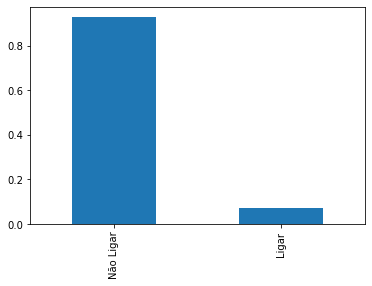

In [8]:
# distribuição de ligar vs. não ligar
# porcentagem da base que será contactada: ~95%
print (df_lista_ligacao['Flag_Ligar'].value_counts(dropna=False, normalize=True))
df_plot = df_lista_ligacao['Flag_Ligar'].value_counts(dropna=False, normalize=True)
df_plot.plot(kind='bar')